# Credit Card Fraud Detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,auc,roc_auc_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
import _pickle as cPickle
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split 

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
plt.style.use('fivethirtyeight')

In [2]:
path='./data/creditcard.csv'

In [3]:
data=pd.read_csv(path)

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Visualizing Data

Class as pie chart:


Text(0, 0.5, '')

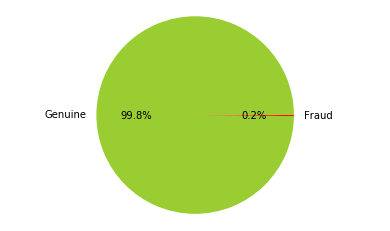

In [5]:
# Check Class variables that has 0 value for Genuine transactions and 1 for Fraud
print("Class as pie chart:")
fig, ax = plt.subplots(1, 1)
ax.pie(data.Class.value_counts(),autopct='%1.1f%%', labels=['Genuine','Fraud'], colors=['yellowgreen','r'])
plt.axis('equal')
plt.ylabel('')

### Checking features

#### This shows that number of transactions have similar dependence on time of the day for both classes. So it doesn't hold any predictive power.

In [6]:
data = data.drop(['Time'],axis=1)

### Their are transactions of more than 10k in legit case only so this is an feature to check for fraud detection.

## Applying Standardization 

In [7]:
from sklearn.preprocessing import StandardScaler
data['scaled_Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data = data.drop(['Amount'],axis=1)

In [8]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


### Train-Test Split

#### Spliting data into 80-20 ration of training and testing

In [9]:
def split_data(df,drop_list):
    df=df.drop(drop_list,axis=1)
    X=data[data['Class']==1]
    Y=data[data['Class']==0]
    X=data.drop(['Class'], axis = 1) 
    Y=data["Class"] 
    xData = X.values 
    yData = Y.values 
    xTrain, xTest, yTrain, yTest = train_test_split( 
            xData, yData, test_size = 0.2, random_state = 42)
    return xTrain, xTest, yTrain, yTest

### Prediction Function

In [10]:
def get_predictions(clf, X_train, y_train, X_test):
    # create classifier
    clf = clf
    # fit it to training data
    clf.fit(X_train,y_train)
    # predict using test data
    y_pred = clf.predict(X_test)
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = clf.predict_proba(X_test)
    #for fun: train-set predictions
    train_pred = clf.predict(X_train)
    print('train-set confusion matrix:\n', confusion_matrix(y_train,train_pred)) 
    return y_pred, y_pred_prob

In [11]:
scores={}

### Print Score Function

In [12]:
def addValues(y_test,y_pred,model_name):
    scores.update({model_name : {
        'precision_score' : precision_score(y_test,y_pred),
        'recall_score' : recall_score(y_test,y_pred),
        'f1_score' : f1_score(y_test,y_pred),
        'accuracy_score': accuracy_score(y_test,y_pred)
    }})

In [13]:
def print_scores(y_test,y_pred,y_pred_prob):
    print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred)) 
    print("recall score: ", recall_score(y_test,y_pred))
    print("precision score: ", precision_score(y_test,y_pred))
    print("f1 score: ", f1_score(y_test,y_pred))
    print("accuracy score: ", accuracy_score(y_test,y_pred))
    print("ROC AUC: {}".format(roc_auc_score(y_test, y_pred_prob[:,1])))
    #ROC_AUC.append(roc_auc_score(y_test, y_pred_prob[:,1]))

In [14]:
drop_list = ['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8']

In [15]:
Y = data['Class']
X=data.drop(['Class'], axis = 1)

In [16]:
X_resample, y_resample = SMOTE().fit_resample(X, Y)

In [17]:
X_resample.shape

(568630, 29)

In [18]:
OverSampledData = X_resample.copy()
OverSampledData['Class']=y_resample.values

Class as pie chart:


Text(0, 0.5, '')

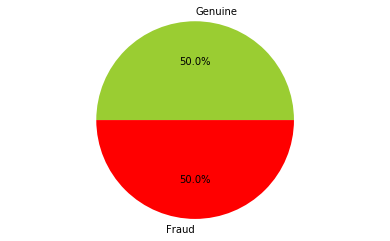

In [19]:
# Check Class variables that has 0 value for Genuine transactions and 1 for Fraud
print("Class as pie chart:")
fig, ax = plt.subplots(1, 1)
ax.pie(OverSampledData.Class.value_counts(),autopct='%1.1f%%', labels=['Genuine','Fraud'], colors=['yellowgreen','r'])
plt.axis('equal')
plt.ylabel('')

In [20]:
x_Train,x_Test,y_Train,y_Test=split_data(OverSampledData,drop_list)

## Naive Bayes Algorithm

**p(A/B) = p(B/A)*p(A) / p(B)**

In [21]:
from sklearn.naive_bayes import GaussianNB

In [22]:
NB_y_pred, NB_y_pred_prob = get_predictions(GaussianNB(),x_Train, y_Train, x_Test)

train-set confusion matrix:
 [[222614   4837]
 [    66    328]]


In [24]:
print_scores(y_Test,NB_y_pred,NB_y_pred_prob)

test-set confusion matrix:
 [[55608  1256]
 [   18    80]]
recall score:  0.8163265306122449
precision score:  0.059880239520958084
f1 score:  0.11157601115760112
accuracy score:  0.9776342122818721
ROC AUC: 0.9671032136827719


In [27]:
addValues(y_Test,NB_y_pred,"Naive Bayes")

In [28]:
scores

{'Naive Bayes': {'precision_score': 0.059880239520958084,
  'recall_score': 0.8163265306122449,
  'f1_score': 0.11157601115760112,
  'accuracy_score': 0.9776342122818721}}

## Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
LR_y_pred, LR_y_pred_prob = get_predictions(LogisticRegression(C = 0.01, penalty = 'l2',max_iter=1000),x_Train, y_Train, x_Test)

train-set confusion matrix:
 [[227423     28]
 [   158    236]]


In [31]:
lr = LogisticRegression(C = 0.01, penalty = 'l2',max_iter=1000)

In [32]:
lr.fit(x_Train, y_Train)

LogisticRegression(C=0.01, max_iter=1000)

In [33]:
ypred = lr.predict(x_Test)
# Compute predicted probabilities: y_pred_prob
ypredProv = lr.predict_proba(x_Test)

In [34]:
print_scores(y_Test,ypred,ypredProv)

test-set confusion matrix:
 [[56855     9]
 [   44    54]]
recall score:  0.5510204081632653
precision score:  0.8571428571428571
f1 score:  0.670807453416149
accuracy score:  0.9990695551420246
ROC AUC: 0.9812063225684196


In [35]:
addValues(y_Test,ypred,"Logistic Regression")

In [36]:
scores

{'Naive Bayes': {'precision_score': 0.059880239520958084,
  'recall_score': 0.8163265306122449,
  'f1_score': 0.11157601115760112,
  'accuracy_score': 0.9776342122818721},
 'Logistic Regression': {'precision_score': 0.8571428571428571,
  'recall_score': 0.5510204081632653,
  'f1_score': 0.670807453416149,
  'accuracy_score': 0.9990695551420246}}

## Linear Discriminant Analysis

In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [38]:
LDA_clf=LinearDiscriminantAnalysis()

In [39]:
#xTrain, xTest, yTrain, yTest = split_data(undersample_df,dropList)

In [40]:
LDA_y_pred, LDA_y_pred_prob = get_predictions(LinearDiscriminantAnalysis(),x_Train, y_Train, x_Test)
print_scores(y_Test,LDA_y_pred,LDA_y_pred_prob)

train-set confusion matrix:
 [[227403     48]
 [    90    304]]
test-set confusion matrix:
 [[56853    11]
 [   25    73]]
recall score:  0.7448979591836735
precision score:  0.8690476190476191
f1 score:  0.8021978021978022
accuracy score:  0.9993679997191109
ROC AUC: 0.9802338985678685


In [41]:
addValues(y_Test,LDA_y_pred,"Linear Discriminant Analysis ")

### Decision Tree

In [42]:
from sklearn.tree import DecisionTreeClassifier

In [46]:
DT = DecisionTreeClassifier()

In [47]:
DT.fit(x_Train,y_Train)

DecisionTreeClassifier()

In [48]:
with open('OverSampled/DecisionTree.pkl', 'wb') as fid:
    cPickle.dump(DT, fid)

In [49]:
with open('OverSampled/DecisionTree.pkl', 'rb') as fid:
    Dtree = cPickle.load(fid)

In [50]:
DT_preds = Dtree.predict(x_Test)

In [51]:
addValues(y_Test,DT_preds,"Decision Tree")

In [52]:
scores['Decision Tree']

{'precision_score': 0.7238095238095238,
 'recall_score': 0.7755102040816326,
 'f1_score': 0.7487684729064038,
 'accuracy_score': 0.9991046662687406}

### Random Forest

### Applying Ensemble techniques

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
RF_clf = RandomForestClassifier()

In [ ]:
RF_clf.fit(x_Train, y_Train)

In [ ]:
with open('OverSampled/RandomForest.pkl', 'wb') as fid:
    cPickle.dump(RF_clf, fid)

In [56]:
with open('OverSampled/RandomForest.pkl', 'rb') as fid:
    RF_clf = cPickle.load(fid)

In [57]:
RF_y_pred = RF_clf.predict(x_Test)

In [58]:
addValues(y_Test,RF_y_pred,"Random Forest Classifier")

In [59]:
scores['Random Forest Classifier']

{'precision_score': 0.975,
 'recall_score': 0.7959183673469388,
 'f1_score': 0.8764044943820225,
 'accuracy_score': 0.9996137776061234}

### Support Vector Machine

In [60]:
from sklearn.svm import SVC

In [61]:
clf = SVC()

In [ ]:
clf.fit(x_Train,y_Train)

In [ ]:
with open('OverSampled/SVM.pkl', 'wb') as fid:
    cPickle.dump(clf, fid)

In [62]:
with open('OverSampled/SVM.pkl', 'rb') as fid:
    SVMclf = cPickle.load(fid)

In [63]:
SVM_pred=SVMclf.predict(x_Test)

In [64]:
addValues(y_Test,SVM_pred,"SVM")

In [65]:
scores['SVM']

{'precision_score': 0.9682539682539683,
 'recall_score': 0.6224489795918368,
 'f1_score': 0.7577639751552796,
 'accuracy_score': 0.9993153330290369}

## DNN

In [66]:
import keras
from keras import layers
from keras.models import load_model

In [67]:
model = keras.Sequential([
layers.Dense(input_dim = 29,units = 16, activation = 'relu'),
layers.Dense(units = 24,activation = 'relu'),

layers.Dropout(0.5),

layers.Dense(units = 24,activation = 'relu'),

layers.Dense(units = 20,activation = 'relu'),

layers.Dense(units =1, activation = 'sigmoid'),])

In [68]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(x_Train, y_Train, batch_size = 32, epochs = 5)

Epoch 1/5
7121/7121 [==============================] - 7s 916us/step - loss: 0.0110 - accuracy: 0.9980
Epoch 2/5
7121/7121 [==============================] - 6s 905us/step - loss: 0.0039 - accuracy: 0.9993
Epoch 3/5
7121/7121 [==============================] - 6s 862us/step - loss: 0.0034 - accuracy: 0.9994
Epoch 4/5
7121/7121 [==============================] - 6s 886us/step - loss: 0.0033 - accuracy: 0.9994
Epoch 5/5
7121/7121 [==============================] - 6s 864us/step - loss: 0.0031 - accuracy: 0.9994


In [69]:
model.save('OverSampled/first.h5')

In [70]:
model = load_model('OverSampled/first.h5')

In [71]:
preds= model.predict(x_Test)

In [72]:
prob=model.predict_proba(x_Test)

Instructions for updating:
Please use `model.predict()` instead.


In [73]:
addValues(y_Test,preds.round(),"DNN")

In [74]:
scores['DNN']

{'precision_score': 0.8461538461538461,
 'recall_score': 0.7857142857142857,
 'f1_score': 0.8148148148148148,
 'accuracy_score': 0.999385555282469}

## Plot

In [75]:
scores

{'Naive Bayes': {'precision_score': 0.059880239520958084,
  'recall_score': 0.8163265306122449,
  'f1_score': 0.11157601115760112,
  'accuracy_score': 0.9776342122818721},
 'Logistic Regression': {'precision_score': 0.8571428571428571,
  'recall_score': 0.5510204081632653,
  'f1_score': 0.670807453416149,
  'accuracy_score': 0.9990695551420246},
 'Linear Discriminant Analysis ': {'precision_score': 0.8690476190476191,
  'recall_score': 0.7448979591836735,
  'f1_score': 0.8021978021978022,
  'accuracy_score': 0.9993679997191109},
 'Decision Tree': {'precision_score': 0.7238095238095238,
  'recall_score': 0.7755102040816326,
  'f1_score': 0.7487684729064038,
  'accuracy_score': 0.9991046662687406},
 'Random Forest Classifier': {'precision_score': 0.975,
  'recall_score': 0.7959183673469388,
  'f1_score': 0.8764044943820225,
  'accuracy_score': 0.9996137776061234},
 'SVM': {'precision_score': 0.9682539682539683,
  'recall_score': 0.6224489795918368,
  'f1_score': 0.7577639751552796,
  'ac

In [76]:
models = list(scores.keys())

In [77]:
ps=[]

In [78]:
for i in scores:
    ps.append(scores[i]['precision_score'])

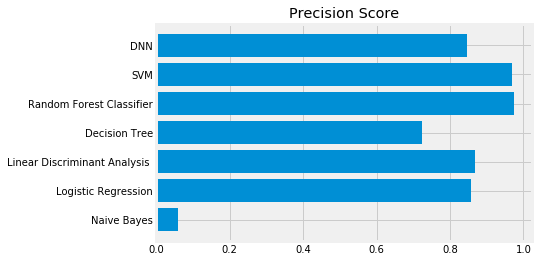

In [79]:
plt.barh(models,ps)
plt.title('Precision Score')
plt.show()

In [80]:
rs=[]

In [81]:
for i in scores:
    rs.append(scores[i]['recall_score'])

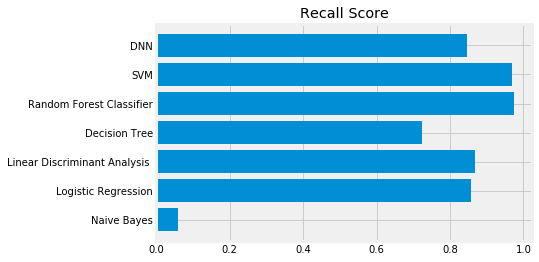

In [82]:
plt.barh(models,ps)
plt.title('Recall Score')
plt.show()

In [83]:
f1=[]

In [84]:
for i in scores:
    f1.append(scores[i]['f1_score'])

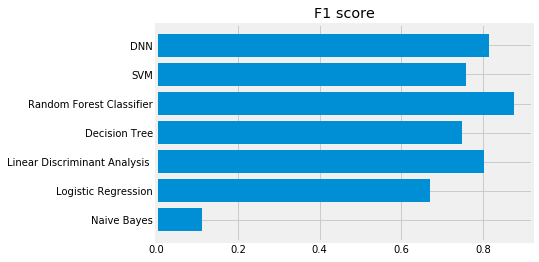

In [85]:
plt.barh(models,f1)
plt.title("F1 score")
plt.show()